<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/convolution_2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
Build intuition for 2D convolution

# Bibliography
* [NCCAT SPA short course 2020, Lecture 4: Algorithms and foundational math Part I & 2, Fred Sigworth](https://youtu.be/tzv5c5K7MEk)
  * See lecture notes under [Single Particle Short Course March 2-6, 2020. Day 3: Wednesday, March 4, 2020, 10:40 – 11:30 AM](https://nccat.nysbc.org/activities/courses/nccat-spa-short-course-2020/)
  * See especially the derivations of 1D convolution, and 2D convlution examples around  1:05:00 - 1:15:00

# Setup

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit

# DFT

In [ ]:
%%bash
rm twod.py
wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/d639f8b94e811e892940b068dcedf57881526e93/code/twod.py
wget https://raw.githubusercontent.com/asarnow/pyem/master/pyem/mrc.py
pip install pyfftw

In [56]:
from twod import *

# Example of 2D Convolution Theorem

In [ ]:
%%bash
wget https://img.favpng.com/6/18/22/flag-of-canada-maple-leaf-national-flag-png-favpng-49GRrhjDnfSzWirc1xSXFnx72.jpg

In [9]:
from PIL import Image
fname = 'flag-of-canada-maple-leaf-national-flag-png-favpng-49GRrhjDnfSzWirc1xSXFnx72.jpg'
image = Image.open(fname).convert('L')

In [61]:
image = np.asarray(image)
nx, ny = image.shape
assert nx == ny

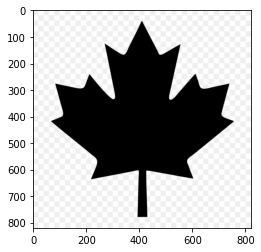

In [53]:
twod.do_2dplot(image)

## Real Space Convolution

2D Gaussian blur

In [124]:
from scipy import signal
gauss_1d = signal.gaussian(nx, std=5)

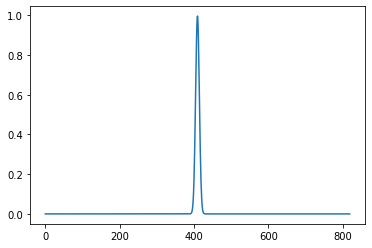

In [125]:
pd.Series(gauss_1d).plot()

We can convolute with a truncated kernel, since it is zero away from the gaussian peak. The speed of the convolution really depends on this.

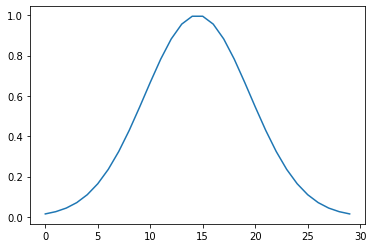

In [127]:
half_width = 15
pd.Series(gauss_1d[nx//2-half_width:nx//2+half_width]).plot()

In 2D

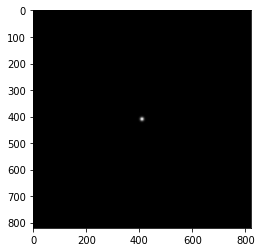

In [128]:
gauss_2d = np.multiply(gauss_1d.reshape(nx,1), gauss_1d.reshape(1,nx))
do_2dplot(gauss_2d)

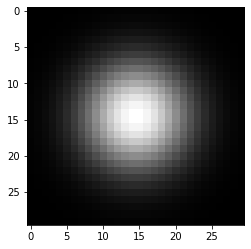

In [129]:
kernel_2d = gauss_2d[nx//2-half_width:nx//2+half_width,nx//2-half_width:nx//2+half_width]
do_2dplot(kernel_2d)

In [130]:
@jit
def convolution_2d(arr,kernel):
  '''
  edges are just left as zero from initialization
  '''
  new = np.zeros_like(arr)
  assert arr.ndim==2
  assert kernel.ndim == 2
  kx,ky = kernel.shape
  assert kx == ky
  assert kx%2 == 0 # even
  I,J = arr.shape
  for i in range(I):
    if i - kx >= 0 and i + kx < I:
      for j in range(J):
        if j - kx >= 0 and j + kx < J:
          new[i,j] = np.multiply(arr[i-kx//2:i+kx//2,j-kx//2:j+kx//2], kernel).mean()
  return(new)

blurred = convolution_2d(image,kernel_2d)


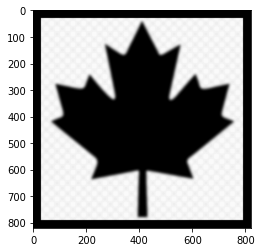

In [131]:
do_2dplot(blurred)

In [100]:
%timeit convolution_2d(image,kernel_2d)

1 loop, best of 3: 1.67 s per loop


## Convolution in Fourier Space
We can take an FFT, do the convolution in Fourier space as a multiplication, and then return to real space.

Let's look at FFTs

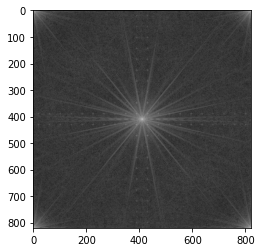

In [132]:
image_f = do_fft(image)
do_2dplot(log_abs(image_f))

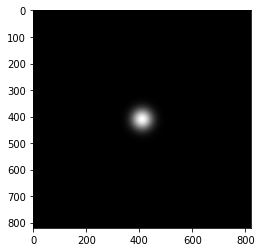

In [133]:
gauss_2d_f = do_fft(gauss_2d)
do_2dplot(log_abs(gauss_2d_f))

Not surprisingly, the FFT of the gaussian is a gaussian. Note that we could have truncated the function, taken the FFT, and then zero padded it. 

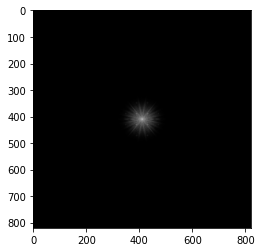

In [134]:
blurred_f = image_f*gauss_2d_f
do_2dplot(log_abs(blurred_f))

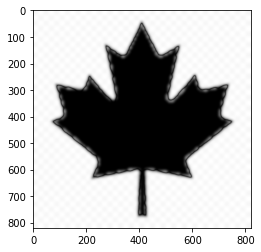

In [135]:
blurred_r = do_ifft(blurred_f)
do_2dplot(log_abs(blurred_r))

Interestingly the image has some ripples and white edges in the Fourier blur, and handles the zero padding.

The differences between real space and Fourier space really depend on the kernel size. Try a large kernel size (`gauss_1d = signal.gaussian(nx, std=20)`) and see how the results are different.